In [6]:
# ============================================================
# 1. IMPOR PUSTAKA YANG DIBUTUHKAN
# ============================================================
import os

# Menyembunyikan log TensorFlow yang berlebihan
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json
from scipy.signal import butter, filtfilt
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Menonaktifkan pesan log dari TensorFlow & Python agar output bersih
tf.get_logger().setLevel(logging.ERROR)

# ============================================================
# 2. PERSIAPAN DIREKTORI UNTUK KASUS E
# ============================================================
print("🚀 Membuat direktori untuk Kasus E (Klasifikasi Gerakan)...")

os.makedirs("saved_models_kasus_e", exist_ok=True)
os.makedirs("tflite_models_kasus_e_float", exist_ok=True)
os.makedirs("tflite_models_kasus_e_int8", exist_ok=True)
os.makedirs("headers_kasus_e_float", exist_ok=True)
os.makedirs("headers_kasus_e_int8", exist_ok=True)

print("✅ Direktori siap untuk Kasus E – pipeline TinyML gerakan tubuh.")

🚀 Membuat direktori untuk Kasus E (Klasifikasi Gerakan)...
✅ Direktori siap untuk Kasus E – pipeline TinyML gerakan tubuh.


In [7]:
# ============================================================
# 3. MEMUAT & MEMPROSES DATA (Kasus E, Versi Aman dari Leakage)
# ============================================================
print("🚀 Memuat data sensor (idle, walk, jog) dan memproses fitur (versi non-leak)...")

# ---------- Konfigurasi ----------
FILES = {
    "idle": "idle_0002.csv",
    "walk": "walk_0003.csv",
    "jog":  "jog_0005.csv",
}
SR_HZ        = 50
WINDOW_SEC   = 2.0
WINDOW_SIZE  = int(WINDOW_SEC * SR_HZ)   # 100 sampel
STEP         = WINDOW_SIZE // 2          # overlap 50 %
LPF_CUTOFF_HZ= 5.0
LPF_ORDER    = 4
SENSOR_COLS  = ["accX","accY","accZ","gyroX","gyroY","gyroZ"]

# ---------- 1) Load CSV + gabung ----------
dfs = []
for label, path in FILES.items():
    df = pd.read_csv(path, comment="#")
    df["activity"] = label
    df["source"] = path
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Total data mentah: {len(df_all)} sampel dari {len(FILES)} aktivitas.")

# ---------- 2) Low-pass filter ----------
def butter_lowpass_filter(series, cutoff=LPF_CUTOFF_HZ, fs=SR_HZ, order=LPF_ORDER):
    b, a = butter(order, cutoff / (0.5 * fs), btype="low")
    return filtfilt(b, a, series)

for c in SENSOR_COLS:
    df_all[c] = butter_lowpass_filter(df_all[c].values)

# ---------- 3) Windowing + metadata blok ----------
X_list, y_list, group_list = [], [], []
for label, src in FILES.items():
    df_sub = df_all[df_all.source == src]
    data = df_sub[SENSOR_COLS].to_numpy(np.float32)
    for start in range(0, len(data) - WINDOW_SIZE + 1, STEP):
        X_list.append(data[start:start + WINDOW_SIZE])
        y_list.append(label)
        block_id = start // WINDOW_SIZE
        group_list.append(f"{src}::{block_id}")   # identitas blok non-overlap

X_all = np.array(X_list, np.float32)
y_all = np.array(y_list)
groups = np.array(group_list)
print(f"Total window terbentuk: {len(X_all)} (masing-masing {WINDOW_SIZE} sampel)")

# ---------- 4) Label encode ----------
le = LabelEncoder()
y_enc = le.fit_transform(y_all)
num_classes = len(le.classes_)
print("Label mapping:", dict(zip(le.classes_, range(num_classes))))

# ---------- 5) Split berbasis grup (hindari leakage) ----------
# Pertama: pisahkan test
gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
train_idx, test_idx = next(gss.split(X_all, y_enc, groups))

# Dari sisa, pisahkan val
X_tmp, y_tmp, grp_tmp = X_all[train_idx], y_enc[train_idx], groups[train_idx]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.10/0.90, random_state=43)  # 10% total
train2_idx, val_idx = next(gss2.split(X_tmp, y_tmp, grp_tmp))

X_train, y_train = X_tmp[train2_idx], y_tmp[train2_idx]
X_val,   y_val   = X_tmp[val_idx],     y_tmp[val_idx]
X_test,  y_test  = X_all[test_idx],    y_enc[test_idx]

# Acak urutan dalam tiap subset
X_train, y_train = shuffle(X_train, y_train, random_state=1)
X_val,   y_val   = shuffle(X_val,   y_val,   random_state=2)
X_test,  y_test  = shuffle(X_test,  y_test,  random_state=3)

# ---------- 6) Normalisasi (fit dari TRAIN saja) ----------
scaler = StandardScaler()
Xtr2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(Xtr2d)

def apply_scale(X):
    X2d = X.reshape(-1, X.shape[-1])
    return scaler.transform(X2d).reshape(X.shape).astype(np.float32)

X_train = apply_scale(X_train)
X_val   = apply_scale(X_val)
X_test  = apply_scale(X_test)

# ---------- Rekap ----------
print("\n✅ Split non-leakage selesai:")
for cls, name in enumerate(le.classes_):
    print(f"   {name:<5} | train={np.sum(y_train==cls):4d} | val={np.sum(y_val==cls):3d} | test={np.sum(y_test==cls):3d}")

print(f"\nFinal shapes:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# ---------- Simpan ----------
np.save("X_train.npy", X_train)
np.save("X_val.npy",   X_val)
np.save("X_test.npy",  X_test)
np.save("y_train.npy", y_train)
np.save("y_val.npy",   y_val)
np.save("y_test.npy",  y_test)

with open("scaler_stats_kasuse.json","w") as f:
    json.dump({"mean":scaler.mean_.tolist(),
               "scale":scaler.scale_.tolist(),
               "feature_order":SENSOR_COLS}, f, indent=2)

with open("label_mapping_kasuse.json","w") as f:
    json.dump({int(i):cls for i,cls in enumerate(le.classes_)}, f, indent=2)

print("\n💾 Dataset non-leak disimpan:")
print("   - X_train.npy, X_val.npy, X_test.npy")
print("   - y_train.npy, y_val.npy, y_test.npy")
print("   - scaler_stats_kasuse.json, label_mapping_kasuse.json")


🚀 Memuat data sensor (idle, walk, jog) dan memproses fitur (versi non-leak)...
Total data mentah: 45000 sampel dari 3 aktivitas.
Total window terbentuk: 897 (masing-masing 100 sampel)
Label mapping: {'idle': 0, 'jog': 1, 'walk': 2}

✅ Split non-leakage selesai:
   idle  | train= 241 | val= 22 | test= 36
   jog   | train= 251 | val= 30 | test= 18
   walk  | train= 225 | val= 38 | test= 36

Final shapes:
   X_train: (717, 100, 6), y_train: (717,)
   X_val:   (90, 100, 6),   y_val:   (90,)
   X_test:  (90, 100, 6),  y_test:  (90,)

💾 Dataset non-leak disimpan:
   - X_train.npy, X_val.npy, X_test.npy
   - y_train.npy, y_val.npy, y_test.npy
   - scaler_stats_kasuse.json, label_mapping_kasuse.json


In [8]:
# ============================================================
# 4. TRAINING, EVALUASI, DAN PENGUMPULAN HASIL (Kasus E)
# ============================================================

print("\n🚀 Memuat dataset window (X_*, y_*)...\n")

# --- Load data dari preprocessing ---
X_train = np.load("X_train.npy")
X_val   = np.load("X_val.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")
y_test  = np.load("y_test.npy")

num_classes = len(np.unique(y_train))
print(f"Dataset siap: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}, Classes={num_classes}")

# Flatten karena MLP (tanpa CNN/RNN)
x_train = X_train.reshape(X_train.shape[0], -1)
x_val   = X_val.reshape(X_val.shape[0], -1)
x_test  = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding untuk output softmax
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

# ------------------------------------------------------------
# Konfigurasi model: (jumlah hidden layer, jumlah neuron/layer)
# ------------------------------------------------------------
model_configs = [(1, 8), (2, 16), (3, 32), (4, 64)]

# Penampung hasil
all_train_loss_histories, all_val_loss_histories = [], []
all_best_val_losses, all_test_losses = [], []
all_best_val_accuracies, all_test_accuracies = [], []
all_precisions, all_recalls, all_f1s = [], [], []
all_best_epochs, model_labels = [], []

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=30, restore_best_weights=True, verbose=1
)

print("\n🚀 Memulai training semua model Multikelas (Dengan Early Stopping)...\n")

for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    print(f"--- Memproses Model {idx} ({num_layers}L, {neurons}N) ---")

    # Buat model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(x_train.shape[1],)))
    model.add(tf.keras.layers.BatchNormalization())

    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))

    # Output softmax (multiclass)
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Simpan model
    model_path = f"saved_models_kasus_e/model_{idx}_{num_layers}L_{neurons}N.keras"
    model.save(model_path)

    # Epoch terbaik
    best_epoch_index = np.argmin(history.history['val_loss'])
    all_train_loss_histories.append(history.history['loss'])
    all_val_loss_histories.append(history.history['val_loss'])
    all_best_epochs.append(best_epoch_index + 1)

    # Evaluasi di val & test
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Prediksi & metrik
    y_pred_prob = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Simpan hasil
    all_best_val_losses.append(val_loss)
    all_best_val_accuracies.append(val_acc)
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_acc)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

    model_labels.append(f"Model {idx}\n({num_layers}L, {neurons}N)")

    # Ringkasan hasil tiap model
    print(f"  Akurasi Validasi: {val_acc*100:.2f}%")
    print(f"  Akurasi Test:     {test_acc*100:.2f}%")
    print(f"  Precision (W):    {precision*100:.2f}%")
    print(f"  Recall (W):       {recall*100:.2f}%")
    print(f"  F1-Score (W):     {f1*100:.2f}%")
    print(f"  Loss Test:        {test_loss:.4f}")
    print("-" * 50)

print("\n🏁 Pengumpulan Data Selesai.\n")



🚀 Memuat dataset window (X_*, y_*)...

Dataset siap: Train=(717, 100, 6), Val=(90, 100, 6), Test=(90, 100, 6), Classes=3

🚀 Memulai training semua model Multikelas (Dengan Early Stopping)...

--- Memproses Model 1 (1L, 8N) ---
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 157.
  Akurasi Validasi: 97.78%
  Akurasi Test:     97.78%
  Precision (W):    97.89%
  Recall (W):       97.78%
  F1-Score (W):     97.78%
  Loss Test:        0.0757
--------------------------------------------------
--- Memproses Model 2 (2L, 16N) ---
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 15.
  Akurasi Validasi: 96.67%
  Akurasi Test:     97.78%
  Precision (W):    97.81%
  Recall (W):       97.78%
  F1-Score (W):     97.77%
  Loss Test:        0.0486
--------------------------------------------------
--- Memproses Model 3 (3L, 32N) ---
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 9.
  Akurasi Validasi


📊 Membuat 5 plot untuk menganalisis hasil Kasus E...



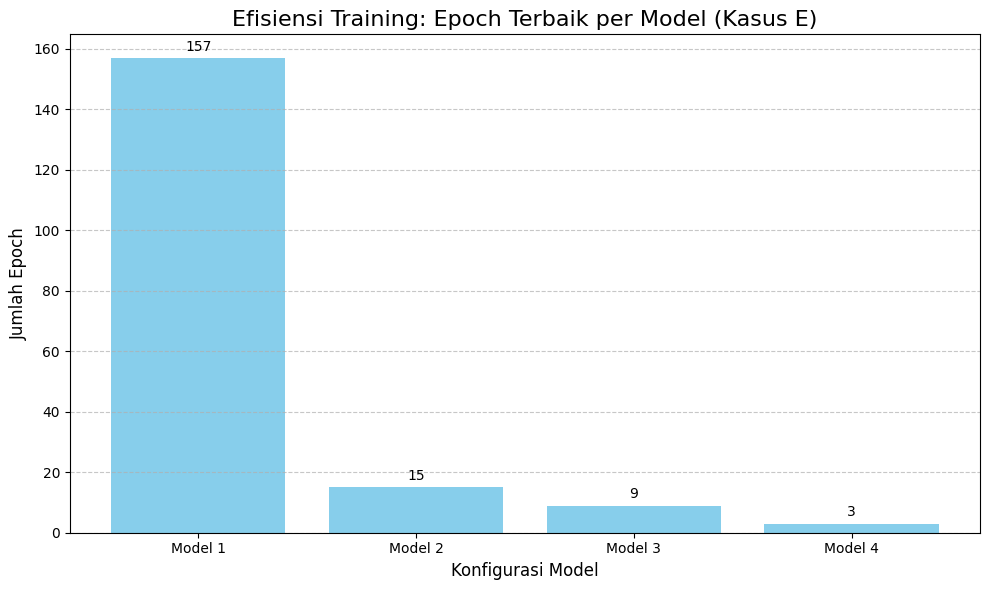

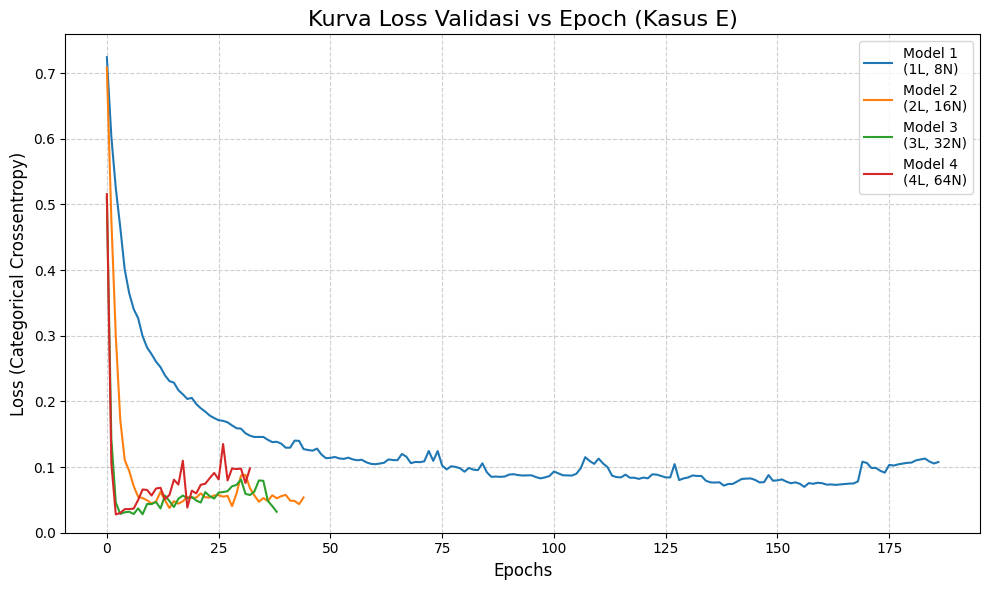

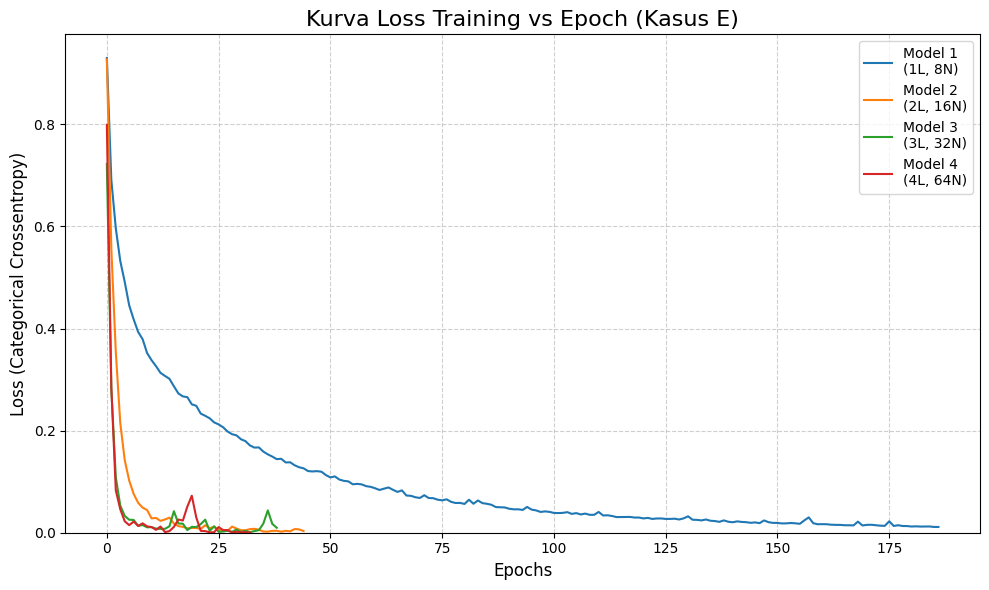

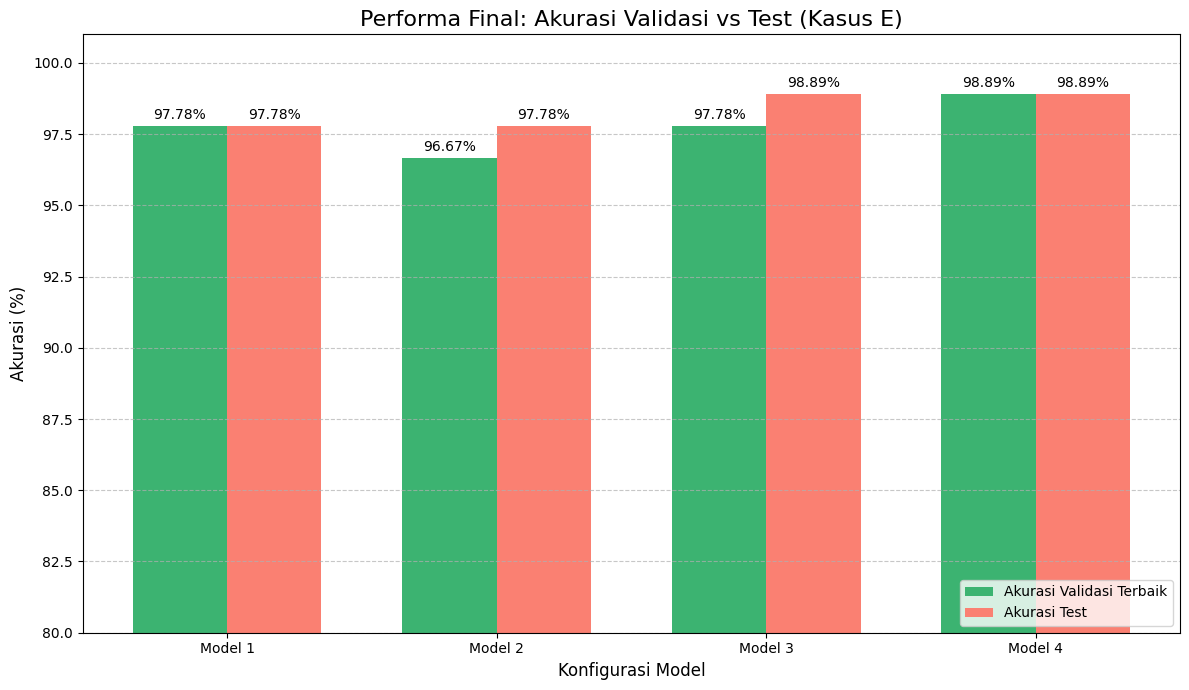

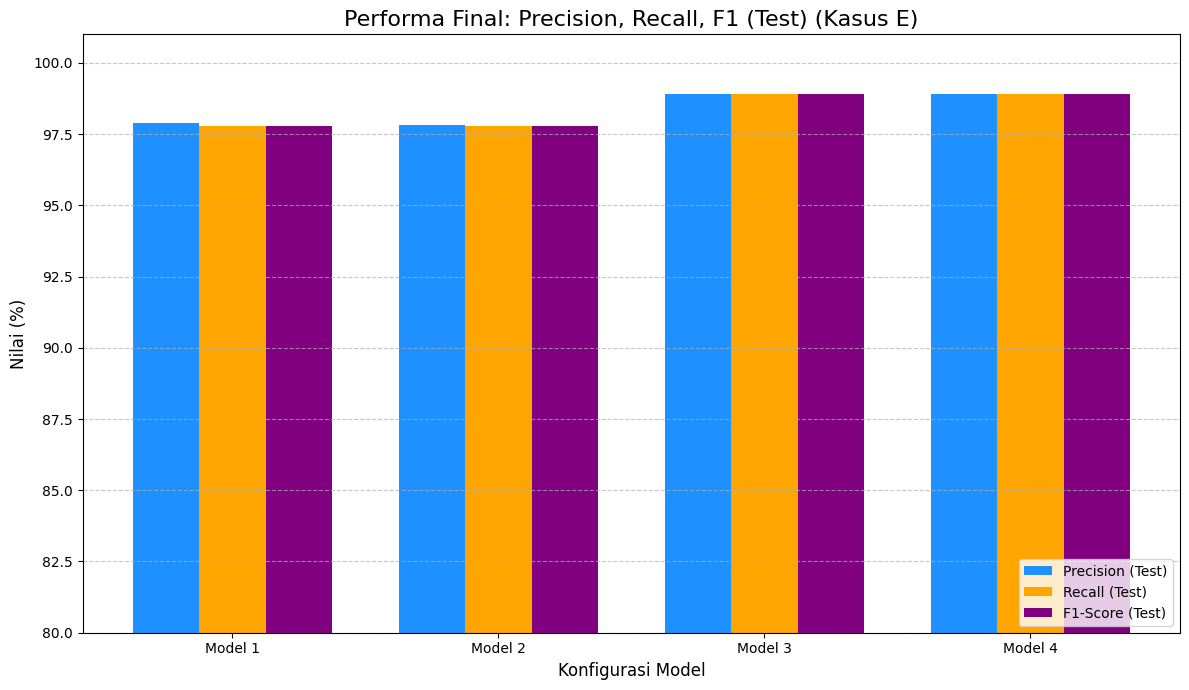


🏁 Visualisasi Kasus E selesai.



In [9]:
# ============================================================
# 5. VISUALISASI HASIL TRAINING (Kasus E)
# ============================================================
print("\n📊 Membuat 5 plot untuk menganalisis hasil Kasus E...\n")

import matplotlib.pyplot as plt
import numpy as np

# Label singkat untuk tiap model
short_labels = [f'Model {i+1}' for i in range(len(model_configs))]
x_pos = np.arange(len(short_labels))
width = 0.35

# ------------------------------------------------------------
# Plot 1: Epoch Terbaik (early stopping)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
bars_epoch = plt.bar(short_labels, all_best_epochs, color='skyblue')
plt.title('Efisiensi Training: Epoch Terbaik per Model (Kasus E)', fontsize=16)
plt.ylabel('Jumlah Epoch', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar_label(bars_epoch, padding=3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 2: Kurva Loss Validasi vs Epoch
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_val_loss_histories):
    plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Validasi vs Epoch (Kasus E)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 3: Kurva Loss Training vs Epoch
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_train_loss_histories):
    plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Training vs Epoch (Kasus E)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 4: Perbandingan Akurasi Validasi vs Test
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
rects1 = plt.bar(x_pos - width/2, [acc * 100 for acc in all_best_val_accuracies],
                 width, label='Akurasi Validasi Terbaik', color='mediumseagreen')
rects2 = plt.bar(x_pos + width/2, [acc * 100 for acc in all_test_accuracies],
                 width, label='Akurasi Test', color='salmon')

plt.title('Performa Final: Akurasi Validasi vs Test (Kasus E)', fontsize=16)
plt.ylabel('Akurasi (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.bar_label(rects1, padding=3, fmt='%.2f%%')
plt.bar_label(rects2, padding=3, fmt='%.2f%%')
plt.ylim(80, 101)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 5: Precision / Recall / F1 (Test)
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
bar_width = 0.25
plt.bar(x_pos - bar_width, [p * 100 for p in all_precisions],
        bar_width, label='Precision (Test)', color='dodgerblue')
plt.bar(x_pos, [r * 100 for r in all_recalls],
        bar_width, label='Recall (Test)', color='orange')
plt.bar(x_pos + bar_width, [f * 100 for f in all_f1s],
        bar_width, label='F1-Score (Test)', color='purple')

plt.title('Performa Final: Precision, Recall, F1 (Test) (Kasus E)', fontsize=16)
plt.ylabel('Nilai (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.ylim(80, 101)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n🏁 Visualisasi Kasus E selesai.\n")


In [10]:
# ============================================================
# 6. EKSPOR DATA UJI KE FORMAT C HEADER (Kasus E)
# ============================================================

print("\n🚀 Mengekspor keseluruhan data uji Kasus E ke format C array (.h)...")

import numpy as np

# ============================================================
# Konfigurasi ekspor
# ============================================================
output_header_path = "test_data_kasus_e.h"

# Load data hasil preprocessing & training
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Flatten setiap window (100×6 = 600 fitur)
x_test_to_export = X_test.reshape(X_test.shape[0], -1).astype(np.float32)
y_test_to_export = y_test.astype(np.int32)

num_test_samples = x_test_to_export.shape[0]
num_features = x_test_to_export.shape[1]

# ============================================================
# Fungsi pembantu untuk format ke array C
# ============================================================
def format_array_to_c(array, var_name, var_type="float"):
    flat = array.flatten()
    if var_type == "float":
        formatted = ", ".join([f"{v:.8f}f" for v in flat])
    else:
        formatted = ", ".join([str(int(v)) for v in flat])
    return f"const {var_type} {var_name}[] = {{ {formatted} }};"

# ============================================================
# Konversi NumPy → string array C
# ============================================================
c_features_array = format_array_to_c(x_test_to_export, "test_features_e", "float")
c_labels_array   = format_array_to_c(y_test_to_export, "test_labels_e", "int")

# ============================================================
# Susun konten file header
# ============================================================
header_content = f"""
// ============================================================
// File ini berisi {num_test_samples} sampel data uji untuk Kasus E
// (Klasifikasi Gerakan: idle=0, jog=1, walk=2)
// Digunakan untuk validasi model TensorFlow Lite di ESP32
// ============================================================

#ifndef TEST_DATA_KASUS_E_H
#define TEST_DATA_KASUS_E_H

const int TEST_SAMPLES_COUNT_E = {num_test_samples};
const int FEATURES_PER_SAMPLE_E = {num_features};

// Data fitur uji (X_test) — tiap sampel memiliki 600 fitur (100×6)
{c_features_array}

// Label sebenarnya (y_test): 0=idle, 1=jog, 2=walk
{c_labels_array}

#endif // TEST_DATA_KASUS_E_H
"""

# ============================================================
# Tulis ke file
# ============================================================
with open(output_header_path, "w") as f:
    f.write(header_content)

print(f"✅ Data uji berhasil diekspor ke file header: '{output_header_path}'")
print(f"   Jumlah sampel: {num_test_samples}, fitur per sampel: {num_features}")
print("   File ini siap digunakan di firmware ESP32 untuk pengujian model.\n")



🚀 Mengekspor keseluruhan data uji Kasus E ke format C array (.h)...
✅ Data uji berhasil diekspor ke file header: 'test_data_kasus_e.h'
   Jumlah sampel: 90, fitur per sampel: 600
   File ini siap digunakan di firmware ESP32 untuk pengujian model.



In [11]:
# ============================================================
# 7. MEMBUAT REPRESENTATIVE DATASET UNTUK KUANTISASI (Kasus E)
# ============================================================

print("\n🚀 Membuat fungsi representative dataset (Kasus E)...")

import numpy as np

# Pastikan x_train sudah ada dari hasil flatten sebelumnya
# Jika belum, jalankan:
# X_train = np.load("X_train.npy")
# x_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32)

def representative_dataset_generator():
    """
    Generator untuk menyediakan subset data latih
    yang digunakan saat konversi model ke format INT8.
    Ini membantu kalibrasi skala kuantisasi berdasarkan distribusi data nyata.
    """
    num_samples = min(100, len(x_train))  # gunakan max 100 sampel acak
    indices = np.random.choice(np.arange(len(x_train)), size=num_samples, replace=False)
    
    for i in indices:
        sample = x_train[i].reshape(1, -1)  # (1, 600)
        yield [sample.astype(np.float32)]

print("✅ Fungsi 'representative_dataset_generator' berhasil dibuat.")
print("   Fungsi ini siap digunakan untuk proses konversi model ke INT8.")



🚀 Membuat fungsi representative dataset (Kasus E)...
✅ Fungsi 'representative_dataset_generator' berhasil dibuat.
   Fungsi ini siap digunakan untuk proses konversi model ke INT8.



🚀 Memulai konversi ke TFLite dan pembuatan header untuk Kasus E...

Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpoy51xvmh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 600), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2149859508880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859508304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149760466768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859509456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859509840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859510992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859511184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859511760: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Header FLOAT dibuat: headers_kasus_e_float/model_e_1_float.h (20.90 KB)
Saved a

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Header INT8 dibuat: headers_kasus_e_int8/model_e_1_int8.h (6.86 KB)

Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp50dk23si'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 600), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2149800641744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800643280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149760464656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800640784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800644048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800650384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800645200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800642512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149800640592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  214978078

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Header INT8 dibuat: headers_kasus_e_int8/model_e_2_int8.h (12.40 KB)

Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpuxz4hmey'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 600), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2151776344912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776348368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776349712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776347024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776349520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776343376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776348752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776341264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2151776347600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21517763

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Header INT8 dibuat: headers_kasus_e_int8/model_e_3_int8.h (24.30 KB)

Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpjudoitc1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 600), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2149859518864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859520208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859518672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859522512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859519248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149859519440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149779800912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149779801680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2149779801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21497798

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Header INT8 dibuat: headers_kasus_e_int8/model_e_4_int8.h (54.25 KB)


📊 Membuat grafik perbandingan ukuran model (Kasus E)...


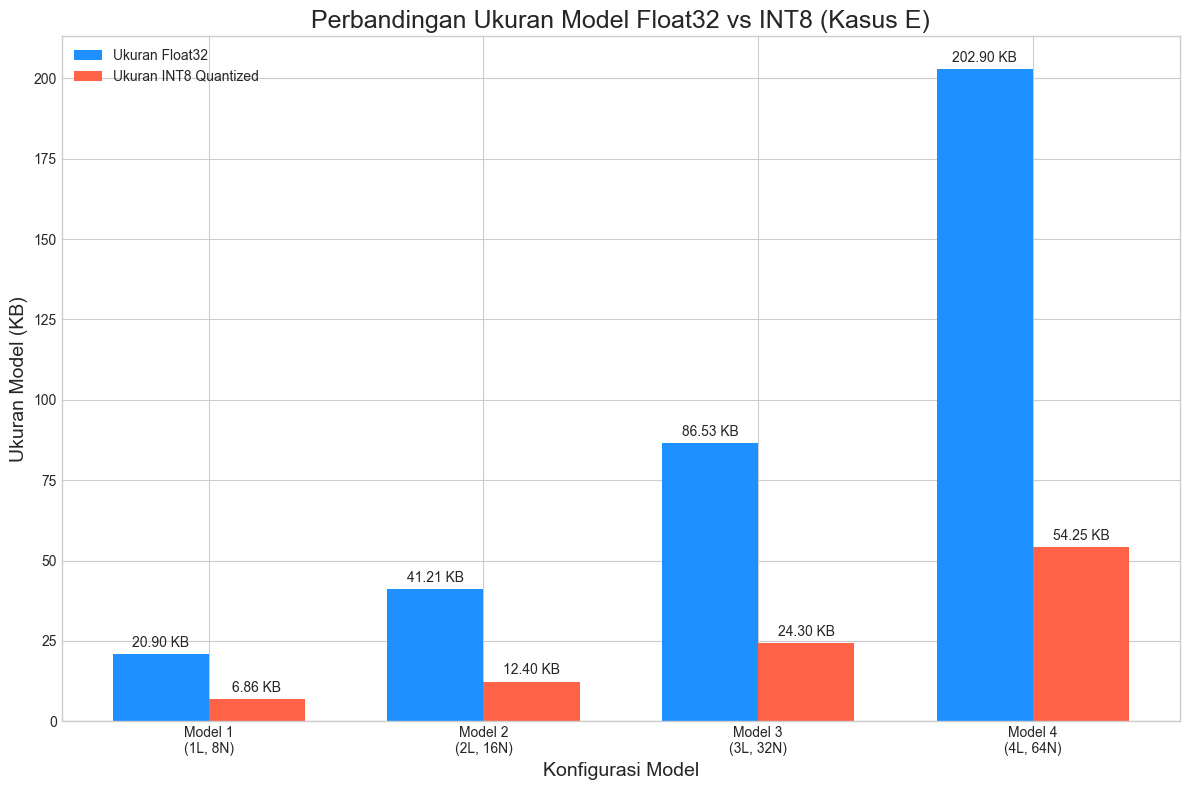


🏁 Konversi dan pembuatan header Kasus E selesai.



In [12]:
# ============================================================
# 8. KONVERSI MODEL KE TFLITE + HEADER C++ (Kasus E)
# ============================================================
# Pastikan folder hasil sudah ada
os.makedirs("tflite_models_kasus_e_float", exist_ok=True)
os.makedirs("tflite_models_kasus_e_int8", exist_ok=True)
os.makedirs("headers_kasus_e_float", exist_ok=True)
os.makedirs("headers_kasus_e_int8", exist_ok=True)

# ============================================================
# 8.1 Fungsi pembuat header C++
# ============================================================
def convert_to_header(tflite_model, filename, model_name, description=""):
    """
    Mengubah file .tflite menjadi array heksadesimal untuk disertakan di firmware ESP32.
    """
    hex_array = ','.join(f'0x{b:02x}' for b in tflite_model)
    c_var_name = f"g_{model_name.lower().replace(' ', '_').replace('-', '_')}"
    header = f'''// File ini dibuat secara otomatis
#ifndef {c_var_name.upper()}_H
#define {c_var_name.upper()}_H

// Model: {model_name}
// {description}
// Size: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)
const unsigned char {c_var_name}_model_data[] = {{{hex_array}}};
const unsigned int {c_var_name}_model_data_len = {len(tflite_model)};

#endif // {c_var_name.upper()}_H
'''
    with open(filename, 'w') as f:
        f.write(header)

# ============================================================
# 8.2 Inisialisasi variabel untuk rekap ukuran
# ============================================================
model_labels_plot = []
float_sizes = []
int8_sizes = []

print("\n🚀 Memulai konversi ke TFLite dan pembuatan header untuk Kasus E...\n")

# ============================================================
# 8.3 Loop tiap konfigurasi model
# ============================================================
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):

    label = f"Model {idx}\n({num_layers}L, {neurons}N)"
    model_labels_plot.append(label)

    keras_model_path = f"saved_models_kasus_e/model_{idx}_{num_layers}L_{neurons}N.keras"
    model = tf.keras.models.load_model(keras_model_path)

    # --------------------------------------------------------
    # FLOAT32 MODEL
    # --------------------------------------------------------
    converter_float = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model_float = converter_float.convert()

    float_path = f"tflite_models_kasus_e_float/model_e_{idx}_float.tflite"
    with open(float_path, "wb") as f:
        f.write(tflite_model_float)

    header_path_float = f"headers_kasus_e_float/model_e_{idx}_float.h"
    model_name_f = f"Kasus E Model {idx} Float"
    desc_f = f"{num_layers}L, {neurons}N, float32"
    convert_to_header(tflite_model_float, header_path_float, model_name_f, desc_f)

    float_kb = len(tflite_model_float) / 1024
    float_sizes.append(float_kb)
    print(f"✅ Header FLOAT dibuat: {header_path_float} ({float_kb:.2f} KB)")

    # --------------------------------------------------------
    # INT8 MODEL (Full Integer Quantization)
    # --------------------------------------------------------
    converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.representative_dataset = representative_dataset_generator
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.inference_input_type = tf.int8
    converter_int8.inference_output_type = tf.int8
    converter_int8._experimental_disable_per_channel_quantization_for_dense_layers = True

    tflite_model_int8 = converter_int8.convert()

    int8_path = f"tflite_models_kasus_e_int8/model_e_{idx}_int8.tflite"
    with open(int8_path, "wb") as f:
        f.write(tflite_model_int8)

    header_path_int8 = f"headers_kasus_e_int8/model_e_{idx}_int8.h"
    model_name_q = f"Kasus E Model {idx} INT8"
    desc_q = f"{num_layers}L, {neurons}N, INT8 quantized"
    convert_to_header(tflite_model_int8, header_path_int8, model_name_q, desc_q)

    int8_kb = len(tflite_model_int8) / 1024
    int8_sizes.append(int8_kb)
    print(f"✅ Header INT8 dibuat: {header_path_int8} ({int8_kb:.2f} KB)\n")

# ============================================================
# 8.4 Plot perbandingan ukuran
# ============================================================
print("\n📊 Membuat grafik perbandingan ukuran model (Kasus E)...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

x = np.arange(len(model_labels_plot))
width = 0.35

rects1 = plt.bar(x - width/2, float_sizes, width, label='Ukuran Float32', color='dodgerblue')
rects2 = plt.bar(x + width/2, int8_sizes,  width, label='Ukuran INT8 Quantized', color='tomato')

plt.title('Perbandingan Ukuran Model Float32 vs INT8 (Kasus E)', fontsize=18)
plt.ylabel('Ukuran Model (KB)', fontsize=14)
plt.xlabel('Konfigurasi Model', fontsize=14)
plt.xticks(x, model_labels_plot)
plt.legend()
plt.bar_label(rects1, padding=3, fmt='%.2f KB')
plt.bar_label(rects2, padding=3, fmt='%.2f KB')
plt.tight_layout()
plt.show()

print("\n🏁 Konversi dan pembuatan header Kasus E selesai.\n")


In [3]:
# Bagian ini dijalankan setelah Bagian 7 (Konversi Model) selesai
model_configs = [(1, 8), (2, 16), (3, 32), (4, 64)]
import tensorflow as tf
print("\n🚀 Mengekstrak informasi kuantisasi dari setiap model INT8 Kasus E...\n")

# Loop melalui setiap model yang telah dikonversi ke INT8
for idx in range(1, len(model_configs) + 1):
    quant_path = f"tflite_models_kasus_e_int8/model_e_{idx}_int8.tflite"
    
    # Buat interpreter untuk membaca model
    interpreter = tf.lite.Interpreter(model_path=quant_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    print("=" * 50)
    print(f"📦 Info Kuantisasi untuk Model {idx} (Kasus E)")
    print("=" * 50)
    print(f"🔹 Input  scale      : {input_details['quantization'][0]}")
    print(f"🔹 Input  zero point : {input_details['quantization'][1]}")
    print(f"🔹 Output scale      : {output_details['quantization'][0]}")
    print(f"🔹 Output zero point : {output_details['quantization'][1]}")
    print()

print("\n🏁 Ekstraksi informasi selesai.\n")


🚀 Mengekstrak informasi kuantisasi dari setiap model INT8 Kasus E...

📦 Info Kuantisasi untuk Model 1 (Kasus E)
🔹 Input  scale      : 0.06460394710302353
🔹 Input  zero point : -2
🔹 Output scale      : 0.00390625
🔹 Output zero point : -128

📦 Info Kuantisasi untuk Model 2 (Kasus E)
🔹 Input  scale      : 0.0571591779589653
🔹 Input  zero point : -11
🔹 Output scale      : 0.00390625
🔹 Output zero point : -128

📦 Info Kuantisasi untuk Model 3 (Kasus E)
🔹 Input  scale      : 0.0629265084862709
🔹 Input  zero point : -5
🔹 Output scale      : 0.00390625
🔹 Output zero point : -128

📦 Info Kuantisasi untuk Model 4 (Kasus E)
🔹 Input  scale      : 0.06629331409931183
🔹 Input  zero point : 2
🔹 Output scale      : 0.00390625
🔹 Output zero point : -128


🏁 Ekstraksi informasi selesai.

